In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install unrar
!unrar x '/content/drive/MyDrive/Model 2.rar' > /dev/null 2>&1

In [ ]:
# Imports

import os
import glob
import numpy as np
import pandas as pd
from pprint import pprint
import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O inception_v3_weights.h5

--2023-11-26 06:27:17--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights.h5’

inception_v3_weight 100%[===================>]  83.84M   144MB/s    in 0.6s    

2023-11-26 06:27:17 (144 MB/s) - ‘inception_v3_weights.h5’ saved [87910968/87910968]



In [ ]:
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
local_weights_file = './inception_v3_weights.h5'

train_path = "/content/Model 2/train"
valid_path = "/content/Model 2/valid"
test_path = "/content/Model 2/test"

In [ ]:
training_images = []

for root, dirs, files in os.walk(train_path):
    for file in files:
        training_images.append(os.path.join(root, file))

validation_images = []

for root, dirs, files in os.walk(valid_path):
    for file in files:
        validation_images.append(os.path.join(root, file))

In [ ]:
print("Training:")
print("Training Path:" + train_path)
print("Training Classes:" + str(len(os.listdir(train_path))))
print("Training Images:" + str(len(training_images)))

print("\n")

print("Validation:")
print("Validation Path:" + valid_path)
print("Validation Classes:" + str(len(os.listdir(valid_path))))
print("Validation Images:" + str(len(validation_images)))

print("\n")

print("Testing:")
print("Testing Path:" + test_path)
print("Testing Images:" + str(len(os.listdir(os.path.join(test_path, 'test')))))

Training:
Training Path:/content/Model 2/train
Training Classes:47
Training Images:41762


Validation:
Validation Path:/content/Model 2/valid
Validation Classes:47
Validation Images:10417


Testing:
Testing Path:/content/Model 2/test


FileNotFoundError: ignored

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1/255)

test_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size = batch_size,
    class_mode = 'categorical',
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=True
)

validation_generator =  validation_datagen.flow_from_directory(
    valid_path,
    batch_size  = batch_size,
    class_mode  = 'categorical',
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    batch_size  = 1,
    class_mode  = None,
    target_size = (150, 150),
    color_mode="rgb",
    shuffle=False
)

Found 41762 images belonging to 47 classes.
Found 10417 images belonging to 47 classes.
Found 0 images belonging to 0 classes.


In [ ]:
class_dict = train_generator.class_indices
pprint(class_dict)

{'Apple_Black_Rot': 0,
 'Apple_Cedar_Rust': 1,
 'Apple_Healthy': 2,
 'Apple_Scab': 3,
 'Blueberry_Healthy': 4,
 'Cassava_Bacterial_Blight': 5,
 'Cassava_Brown_Streak': 6,
 'Cassava_Green_Mottle': 7,
 'Cassava_Healthy': 8,
 'Cassava_Mosaic_Disease': 9,
 'Cherry_Healthy': 10,
 'Cherry_Powdery_Mildew': 11,
 'Chili_Healthy': 12,
 'Chili_Leaf_Curl': 13,
 'Chili_Leaf_Spot': 14,
 'Chili_Whitefly': 15,
 'Chili_Yellowish': 16,
 'Corn_Common_Rust': 17,
 'Corn_Healthy': 18,
 'Corn_Leaf_Blight': 19,
 'Corn_Leaf_Spot': 20,
 'Grape_Black_Measles': 21,
 'Grape_Black_Rot': 22,
 'Grape_Healthy': 23,
 'Grape_Leaf_Spot': 24,
 'Orange_Citrus_Greening': 25,
 'Peach_Bacterial_Spot': 26,
 'Peach_Healthy': 27,
 'Pepper_Bacterial_Spot': 28,
 'Pepper_Healthy': 29,
 'Potato_Early_Blight': 30,
 'Potato_Healthy': 31,
 'Potato_Late_Blight': 32,
 'Raspberry_Healthy': 33,
 'Squash_Powdery_Mildew': 34,
 'Strawberry_Healthy': 35,
 'Strawberry_Leaf_Scorch': 36,
 'Tomato_Bacterial_Spot': 37,
 'Tomato_Early_Blight': 38,
 

In [ ]:
class_list = list(class_dict.keys())
pprint(class_list)

['Apple_Black_Rot',
 'Apple_Cedar_Rust',
 'Apple_Healthy',
 'Apple_Scab',
 'Blueberry_Healthy',
 'Cassava_Bacterial_Blight',
 'Cassava_Brown_Streak',
 'Cassava_Green_Mottle',
 'Cassava_Healthy',
 'Cassava_Mosaic_Disease',
 'Cherry_Healthy',
 'Cherry_Powdery_Mildew',
 'Chili_Healthy',
 'Chili_Leaf_Curl',
 'Chili_Leaf_Spot',
 'Chili_Whitefly',
 'Chili_Yellowish',
 'Corn_Common_Rust',
 'Corn_Healthy',
 'Corn_Leaf_Blight',
 'Corn_Leaf_Spot',
 'Grape_Black_Measles',
 'Grape_Black_Rot',
 'Grape_Healthy',
 'Grape_Leaf_Spot',
 'Orange_Citrus_Greening',
 'Peach_Bacterial_Spot',
 'Peach_Healthy',
 'Pepper_Bacterial_Spot',
 'Pepper_Healthy',
 'Potato_Early_Blight',
 'Potato_Healthy',
 'Potato_Late_Blight',
 'Raspberry_Healthy',
 'Squash_Powdery_Mildew',
 'Strawberry_Healthy',
 'Strawberry_Leaf_Scorch',
 'Tomato_Bacterial_Spot',
 'Tomato_Early_Blight',
 'Tomato_Healthy',
 'Tomato_Late_Blight',
 'Tomato_Leaf_Curl_Virus',
 'Tomato_Leaf_Mold',
 'Tomato_Leaf_Spot',
 'Tomato_Mosaic_Virus',
 'Tomato_Spi

In [ ]:
train_num = train_generator.samples
valid_num = validation_generator.samples

In [ ]:
inception_model = InceptionV3(input_shape= (150, 150, 3),
                                include_top = False,
                                weights = None)

inception_model.load_weights(local_weights_file)

In [ ]:
for layer in inception_model.layers:
    layer.trainable = False

In [ ]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
last_layer = inception_model.get_layer('mixed9')
print('Last Layer Output Shape:', last_layer.output_shape)
last_output = last_layer.output

Last Layer Output Shape: (None, 3, 3, 2048)


In [ ]:
x = layers.Flatten()(last_output)

x = layers.Dense(2048, activation='relu')(x)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(len(class_dict), activation='softmax')(x)

model = Model(inception_model.input, x)

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_num//batch_size,
    validation_data = validation_generator,
    validation_steps=valid_num//batch_size,
    epochs = 10,
#     callbacks=callbacks_list,
    verbose = 1
)

Epoch 1/10
1305/1305 [==============================] - 335s 245ms/step - loss: 0.7901 - accuracy: 0.7705 - val_loss: 0.4322 - val_accuracy: 0.8603
Epoch 2/10
1305/1305 [==============================] - 319s 244ms/step - loss: 0.4804 - accuracy: 0.8523 - val_loss: 0.4165 - val_accuracy: 0.8780
Epoch 3/10
1305/1305 [==============================] - 319s 244ms/step - loss: 0.4328 - accuracy: 0.8708 - val_loss: 0.4538 - val_accuracy: 0.8735
Epoch 4/10
1305/1305 [==============================] - 326s 250ms/step - loss: 0.4216 - accuracy: 0.8786 - val_loss: 0.4052 - val_accuracy: 0.8878
Epoch 5/10
1305/1305 [==============================] - 321s 246ms/step - loss: 0.4250 - accuracy: 0.8834 - val_loss: 0.3599 - val_accuracy: 0.9006
Epoch 6/10
1305/1305 [==============================] - 320s 245ms/step - loss: 0.4124 - accuracy: 0.8899 - val_loss: 0.3895 - val_accuracy: 0.9023
Epoch 7/10
1305/1305 [==============================] - 316s 242ms/step - loss: 0.4089 - accuracy: 0.8924 - val_

In [ ]:
model.evaluate_generator(
    generator=validation_generator,
    steps=valid_num//batch_size
)

<ipython-input-22-a8f2876687a1>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(


[0.4544757604598999, 0.8940384387969971]

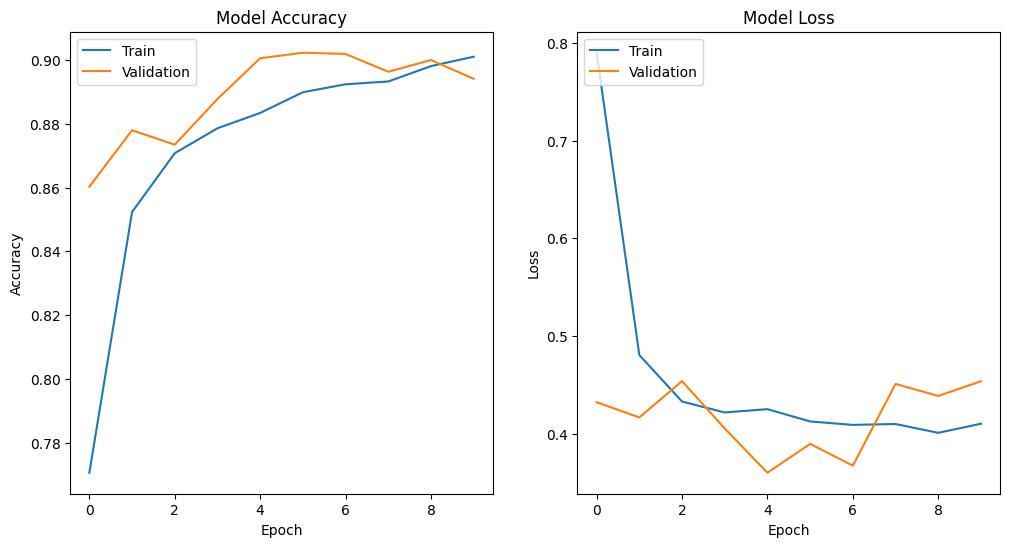

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()